# PyTorch MARL Implementations: IDQL, MADDPG, MAPPO

This notebook contains:

- A small multi-agent grid-world environment
- Independent DQN (IDQL) implementation with neural networks for each agent
- A minimal MADDPG implementation (actor-critic with a centralized critic)
- A MAPPO sketch showing how to implement shared PPO-style updates (centralized value + per-agent policies)
- Replay buffers, networks, simple training loops, checkpoint saving

This notebook is intentionally compact and runnable on a CPU for demonstration; for serious experiments use a GPU and longer training.


## 1) Environment: SimpleGridWorld

Small deterministic grid world for quick experiments. Observations are small vectors so neural nets remain tiny.


In [ ]:

import numpy as np
from PIL import Image, ImageDraw

class SimpleGridWorld:
    ACTIONS = {0:(0,0), 1:(-1,0), 2:(1,0), 3:(0,-1), 4:(0,1)}
    def __init__(self, size=5, max_steps=30, seed=None):
        self.size = size
        self.agents = ['agent_0','agent_1']
        self.max_steps = max_steps
        self.rng = np.random.RandomState(seed)
        self._build_world()

    def _build_world(self):
        self.starts = {'agent_0': (0,0), 'agent_1': (self.size-1,self.size-1)}
        self.goals  = {'agent_0': (self.size-1,self.size-1), 'agent_1': (0,0)}
        self.reset()

    def reset(self):
        self.step_count = 0
        self.positions = dict(self.starts)
        self.done_agents = {a: False for a in self.agents}
        return self._get_obs()

    def _get_obs(self):
        obs = {}
        for a in self.agents:
            own = self.positions[a]
            other = self.positions[self._other(a)]
            goal = self.goals[a]
            obs[a] = np.array([own[0], own[1], other[0], other[1], goal[0], goal[1]], dtype=np.float32)
        return obs

    def _other(self, agent):
        return self.agents[1] if agent == self.agents[0] else self.agents[0]

    def step(self, actions):
        rewards = {}
        infos = {}
        for a, act in actions.items():
            if self.done_agents[a]:
                continue
            dx, dy = self.ACTIONS.get(int(act), (0,0))
            x, y = self.positions[a]
            nx = max(0, min(self.size-1, x + dx))
            ny = max(0, min(self.size-1, y + dy))
            self.positions[a] = (nx, ny)
        if self.positions['agent_0'] == self.positions['agent_1']:
            # revert agent_1 slightly
            self.positions['agent_1'] = (max(0,self.positions['agent_1'][0]-1), self.positions['agent_1'][1])
        for a in self.agents:
            if not self.done_agents[a] and self.positions[a] == self.goals[a]:
                rewards[a] = 1.0
                self.done_agents[a] = True
            else:
                rewards[a] = 0.0
            infos[a] = {}
        self.step_count += 1
        done = all(self.done_agents.values()) or (self.step_count >= self.max_steps)
        dones = {a: self.done_agents[a] for a in self.agents}
        dones['__all__'] = done
        return self._get_obs(), rewards, dones, infos

    def render(self, cell_size=80):
        S = self.size
        img = Image.new('RGB', (S*cell_size, S*cell_size), color=(255,255,255))
        d = ImageDraw.Draw(img)
        for i in range(S+1):
            d.line([(i*cell_size,0),(i*cell_size,S*cell_size)], fill=(200,200,200))
            d.line([(0,i*cell_size),(S*cell_size,i*cell_size)], fill=(200,200,200))
        for a,g in self.goals.items():
            gx, gy = g
            x0, y0 = gy*cell_size, gx*cell_size
            d.rectangle([x0+5, y0+5, x0+cell_size-5, y0+cell_size-5], outline=(180,180,255), width=3)
            d.text((x0+8,y0+8), f'G-{a[-1]}', fill=(0,0,0))
        colors = {'agent_0': (255,100,100), 'agent_1': (100,255,100)}
        for a,pos in self.positions.items():
            px, py = pos
            x0, y0 = py*cell_size, px*cell_size
            d.ellipse([x0+12, y0+12, x0+cell_size-12, y0+cell_size-12], fill=colors[a])
            d.text((x0+12,y0+12), a[-1], fill=(0,0,0))
        return img


## 2) PyTorch utilities: networks, replay buffer, helpers

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Simple MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Replay buffer (shared for IDQL per-agent or centralized for MADDPG)
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)


Using device: cuda


## 3) IDQL — Independent DQN (one DQN per agent)

We implement a small DQN (no target network complexity for brevity, but a target network is recommended).

In [ ]:

class IDQLAgent:
    def __init__(
        self,
        obs_dim,
        n_actions,
        lr=1e-3,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay_steps=5000
    ):
        self.q = MLP(obs_dim, n_actions).to(device)
        self.q_target = MLP(obs_dim, n_actions).to(device)
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.gamma = gamma
        self.n_actions = n_actions

        # epsilon schedule
        self.eps_start = epsilon_start
        self.eps_end = epsilon_end
        self.eps_decay_steps = float(epsilon_decay_steps)
        self.total_steps = 0

    def current_epsilon(self):
        frac = max(0.0, 1.0 - (self.total_steps / self.eps_decay_steps))
        return self.eps_end + (self.eps_start - self.eps_end) * frac

    def act(self, obs):
        eps = self.current_epsilon()
        if random.random() < eps:
            return random.randrange(self.n_actions)
        with torch.no_grad():
            obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            qvals = self.q(obs_t)
            return int(torch.argmax(qvals, dim=1).item())

    def update(self, batch):
        states = torch.tensor(batch.state, dtype=torch.float32, device=device)
        actions = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

        q_values = self.q(states).gather(1, actions)
        with torch.no_grad():
            q_next = self.q_target(next_states).max(1)[0].unsqueeze(1)
            target = rewards + self.gamma * q_next * (1 - dones)
        loss = nn.MSELoss()(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), max_norm=10.0)
        self.optimizer.step()
        return loss.item()

    def sync_target(self):
        self.q_target.load_state_dict(self.q.state_dict())


### IDQL training loop (toy run)

We run a short training loop for a few episodes to demonstrate the pipeline and save checkpoints.

In [ ]:

def train_idql(
    env,
    num_episodes=300,
    batch_size=64,
    buffer_capacity=20000,
    start_learning=1000,
    updates_per_step=1,
    target_update_interval=500,
    seed=1,
    save_dir='./data/pytorch_checkpoints'
):
    # seeding
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    obs_dim = len(env.reset()['agent_0'])
    n_actions = len(SimpleGridWorld.ACTIONS)
    agents = {a: IDQLAgent(obs_dim, n_actions) for a in env.agents}
    buffers = {a: ReplayBuffer(capacity=buffer_capacity) for a in env.agents}
    os.makedirs(save_dir, exist_ok=True)

    episode_rewards = []
    best_avg = -1e9
    total_steps = 0

    for ep in range(num_episodes):
        obs = env.reset()
        total_r = {a: 0.0 for a in env.agents}
        while True:
            # act with epsilon-greedy (decayed inside agent)
            actions = {a: agents[a].act(o) for a, o in obs.items()}
            next_obs, rewards, dones, infos = env.step(actions)

            # store transitions and learn
            for a in env.agents:
                buffers[a].push(obs[a], actions[a], rewards[a], next_obs[a], dones[a])
                total_r[a] += rewards[a]

                if len(buffers[a]) >= batch_size and total_steps >= start_learning:
                    for _ in range(updates_per_step):
                        batch = buffers[a].sample(batch_size)
                        _ = agents[a].update(batch)

            # step counters and target sync
            total_steps += 1
            for a in env.agents:
                agents[a].total_steps += 1
            if total_steps % target_update_interval == 0:
                for a in env.agents:
                    agents[a].sync_target()

            obs = next_obs
            if dones['__all__']:
                break

        ep_return = sum(total_r.values())
        episode_rewards.append(ep_return)

        # periodic logging and checkpointing
        if (ep + 1) % 10 == 0:
            avg_last = float(np.mean(episode_rewards[-20:])) if len(episode_rewards) >= 1 else ep_return
            print(f'Episode {ep+1}/{num_episodes} | Return {ep_return:.2f} | Avg-20 {avg_last:.2f} | Steps {total_steps}')
            torch.save({a: agents[a].q.state_dict() for a in agents}, os.path.join(save_dir, f'idql_ep{ep+1}.pt'))
            if avg_last > best_avg:
                best_avg = avg_last
                torch.save({a: agents[a].q.state_dict() for a in agents}, os.path.join(save_dir, 'idql_best.pt'))

    for a in env.agents:
        agents[a].sync_target()
    return agents, episode_rewards

# Real training run (more robust than the short demo)
env = SimpleGridWorld(size=5, max_steps=30, seed=1)
agents_idql, rewards_idql = train_idql(
    env,
    num_episodes=300,
    batch_size=64,
    buffer_capacity=20000,
    start_learning=200,
    updates_per_step=2,
    target_update_interval=250,
    seed=1
)
print('Finished IDQL training. Checkpoints at ./data/pytorch_checkpoints/')

Episode 10/300 | Return 1.00 | Avg-20 0.40 | Steps 300
Episode 20/300 | Return 0.00 | Avg-20 0.25 | Steps 600
Episode 20/300 | Return 0.00 | Avg-20 0.25 | Steps 600
Episode 30/300 | Return 0.00 | Avg-20 0.25 | Steps 900
Episode 30/300 | Return 0.00 | Avg-20 0.25 | Steps 900
Episode 40/300 | Return 0.00 | Avg-20 0.35 | Steps 1200
Episode 40/300 | Return 0.00 | Avg-20 0.35 | Steps 1200
Episode 50/300 | Return 0.00 | Avg-20 0.15 | Steps 1500
Episode 50/300 | Return 0.00 | Avg-20 0.15 | Steps 1500
Episode 60/300 | Return 1.00 | Avg-20 0.20 | Steps 1800
Episode 60/300 | Return 1.00 | Avg-20 0.20 | Steps 1800
Episode 70/300 | Return 1.00 | Avg-20 0.90 | Steps 2078
Episode 70/300 | Return 1.00 | Avg-20 0.90 | Steps 2078
Episode 80/300 | Return 1.00 | Avg-20 1.40 | Steps 2344
Episode 80/300 | Return 1.00 | Avg-20 1.40 | Steps 2344
Episode 90/300 | Return 2.00 | Avg-20 1.50 | Steps 2551
Episode 90/300 | Return 2.00 | Avg-20 1.50 | Steps 2551
Episode 100/300 | Return 1.00 | Avg-20 1.60 | Steps 2

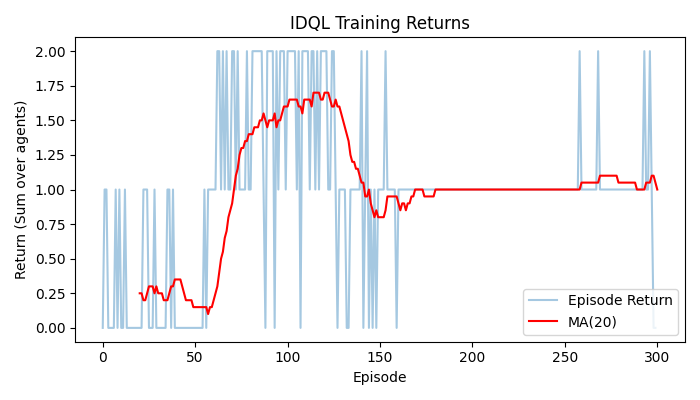

Saved reward plot to ./data/plots/idql_rewards.png


In [ ]:
# Reward curve visualization
import os, math
import matplotlib.pyplot as plt
from IPython.display import Image as IPyImage, display

def moving_average(data, window=20):
    if len(data) < window:
        return data
    cumsum = [0]
    for i,x in enumerate(data,1):
        cumsum.append(cumsum[i-1]+x)
    return [ (cumsum[i]-cumsum[i-window])/window for i in range(window,len(cumsum)) ]

os.makedirs('./data/plots', exist_ok=True)
raw = rewards_idql if 'rewards_idql' in locals() else []
if not raw:
    print('No rewards to plot. Run the training cell first.')
else:
    smoothed = moving_average(raw, window=20)
    plt.figure(figsize=(7,4))
    plt.plot(raw, label='Episode Return', alpha=0.4)
    if len(smoothed)>0 and len(raw)>=20:
        plt.plot(range(20, 20+len(smoothed)), smoothed, label='MA(20)', color='red')
    plt.title('IDQL Training Returns')
    plt.xlabel('Episode')
    plt.ylabel('Return (Sum over agents)')
    plt.legend()
    plt.tight_layout()
    plot_path = './data/plots/idql_rewards.png'
    plt.savefig(plot_path)
    plt.close()
    display(IPyImage(plot_path))
    print('Saved reward plot to', plot_path)

In [ ]:
# Generate evaluation video / GIF of trained agents (greedy policy)
import sys, subprocess, os
import numpy as np
from IPython.display import Video, Image as IPyImage, display

def _ensure(pkgs):
    for p in pkgs:
        try:
            __import__(p if p != 'imageio-ffmpeg' else 'imageio_ffmpeg')
        except Exception:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', p])

_ensure(['imageio', 'imageio-ffmpeg'])
import imageio

os.makedirs('./data/videos', exist_ok=True)

def evaluate_and_record(agents, env_size=5, seed=123, max_steps=60, fps=4, fmt='mp4'):
    env_eval = SimpleGridWorld(size=env_size, max_steps=max_steps, seed=seed)
    obs = env_eval.reset()
    frames = []
    # capture initial frame
    frames.append(np.array(env_eval.render(cell_size=80)))
    step = 0
    while True:
        # greedy actions
        actions = {}
        for a in env_eval.agents:
            with torch.no_grad():
                o = torch.tensor(obs[a], dtype=torch.float32, device=device).unsqueeze(0)
                qv = agents[a].q(o)
                actions[a] = int(torch.argmax(qv, dim=1).item())
        next_obs, rewards, dones, _ = env_eval.step(actions)
        frames.append(np.array(env_eval.render(cell_size=80)))
        obs = next_obs
        step += 1
        if dones['__all__'] or step >= max_steps:
            break
    out_base = './data/videos/idql_episode'
    if fmt == 'mp4':
        try:
            mp4_path = out_base + '.mp4'
            with imageio.get_writer(mp4_path, fps=fps, codec='libx264') as w:
                for fr in frames:
                    w.append_data(fr)
            print('Saved MP4 to', mp4_path)
            return mp4_path
        except Exception as e:
            print('MP4 failed, falling back to GIF:', e)
            fmt = 'gif'
    if fmt == 'gif':
        gif_path = out_base + '.gif'
        imageio.mimsave(gif_path, frames, fps=fps)
        print('Saved GIF to', gif_path)
        return gif_path

video_path = None
if 'agents_idql' in locals():
    video_path = evaluate_and_record(agents_idql, env_size=5, seed=321, max_steps=40, fps=4, fmt='mp4')
else:
    print('No trained agents found. Run the training cell first.')

if video_path:
    try:
        if video_path.endswith('.mp4'):
            display(Video(video_path, embed=True))
        else:
            display(IPyImage(video_path))
    except Exception as _e:
        print('Display failed; file saved at', video_path)

Saved MP4 to ./data/videos/idql_episode.mp4


## 4) MADDPG (centralized critics with full implementation)

Full discrete-action MADDPG style implementation: per-agent centralized critics, target networks, soft updates, replay buffer, training loop.

In [ ]:
# Full MADDPG implementation (discrete actions)
import math, time
from collections import deque, namedtuple

MADDPGTransition = namedtuple('MADDPGTransition', ('state','actions','rewards','next_state','done'))

class MADDPGReplay:
    def __init__(self, capacity=50000):
        self.buf = deque(maxlen=capacity)
    def push(self, *args):
        self.buf.append(MADDPGTransition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        return MADDPGTransition(*zip(*batch))
    def __len__(self):
        return len(self.buf)

class Actor(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)  # logits

class Critic(nn.Module):
    # Centralized critic for ONE agent: input = (all_obs concat + all_actions_onehot)
    def __init__(self, joint_obs_dim, joint_act_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(joint_obs_dim + joint_act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, joint_obs, joint_act):
        x = torch.cat([joint_obs, joint_act], dim=-1)
        return self.net(x).squeeze(-1)

def soft_update(src, tgt, tau):
    for p_src, p_tgt in zip(src.parameters(), tgt.parameters()):
        p_tgt.data.mul_(1-tau).add_(tau * p_src.data)

class MADDPG:
    def __init__(self, env, lr=1e-3, gamma=0.95, tau=0.01, buffer_capacity=50000):
        self.env = env
        self.agents = env.agents
        self.n_agents = len(self.agents)
        self.obs_dim = len(env.reset()[self.agents[0]])
        self.n_actions = len(SimpleGridWorld.ACTIONS)
        self.gamma = gamma
        self.tau = tau

        # Actors + target actors
        self.actors = [Actor(self.obs_dim, self.n_actions).to(device) for _ in range(self.n_agents)]
        self.actors_tgt = [Actor(self.obs_dim, self.n_actions).to(device) for _ in range(self.n_agents)]
        for i in range(self.n_agents):
            self.actors_tgt[i].load_state_dict(self.actors[i].state_dict())
        self.actor_opts = [optim.Adam(a.parameters(), lr=lr) for a in self.actors]

        # Critics per agent + targets
        self.joint_obs_dim = self.n_agents * self.obs_dim
        self.joint_act_dim = self.n_agents * self.n_actions
        self.critics = [Critic(self.joint_obs_dim, self.joint_act_dim).to(device) for _ in range(self.n_agents)]
        self.critics_tgt = [Critic(self.joint_obs_dim, self.joint_act_dim).to(device) for _ in range(self.n_agents)]
        for i in range(self.n_agents):
            self.critics_tgt[i].load_state_dict(self.critics[i].state_dict())
        self.critic_opts = [optim.Adam(c.parameters(), lr=lr) for c in self.critics]

        self.buffer = MADDPGReplay(buffer_capacity)
        self.total_steps = 0

    def _flatten_obs(self, obs_dict):
        parts = []
        for a in self.agents:
            parts.extend(obs_dict[a].tolist())
        return np.asarray(parts, dtype=np.float32)

    def _one_hot_actions(self, actions_list):
        vec = []
        for a in actions_list:
            one = [0]*self.n_actions
            one[int(a)] = 1
            vec.extend(one)
        return np.asarray(vec, dtype=np.float32)

    def select_actions(self, obs_dict, epsilon=0.1):
        acts = []
        for i,a_name in enumerate(self.agents):
            o = torch.tensor(obs_dict[a_name], dtype=torch.float32, device=device).unsqueeze(0)
            logits = self.actors[i](o)
            if random.random() < epsilon:
                act = random.randrange(self.n_actions)
            else:
                act = int(torch.argmax(logits, dim=-1).item())
            acts.append(act)
        return acts

    def push_transition(self, obs, acts, rewards, next_obs, done):
        joint_obs = self._flatten_obs(obs)
        joint_next = self._flatten_obs(next_obs)
        act_onehot = self._one_hot_actions(acts)
        self.buffer.push(joint_obs, act_onehot, [rewards[a] for a in self.agents], joint_next, done)

    def update(self, batch_size=128):
        if len(self.buffer) < batch_size:
            return
        batch = self.buffer.sample(batch_size)
        states = torch.tensor(batch.state, dtype=torch.float32, device=device)
        actions_onehot = torch.tensor(batch.actions, dtype=torch.float32, device=device)
        rewards = torch.tensor(batch.rewards, dtype=torch.float32, device=device)  # shape (B, n_agents)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)  # (B,1)

        # Prepare next actions from target actors
        next_actions_onehot_list = []
        for i in range(self.n_agents):
            # extract each agent's next obs slice
            o_slice = next_states[:, i*self.obs_dim:(i+1)*self.obs_dim]
            logits = self.actors_tgt[i](o_slice)
            probs = torch.softmax(logits, dim=-1)
            # greedy for target
            a_idx = torch.argmax(probs, dim=-1)
            onehot = torch.zeros(probs.shape[0], self.n_actions, device=device)
            onehot.scatter_(1, a_idx.unsqueeze(1), 1.0)
            next_actions_onehot_list.append(onehot)
        next_actions_onehot = torch.cat(next_actions_onehot_list, dim=1)  # (B, n_agents*n_actions)

        # Critic updates
        with torch.no_grad():
            target_qs = []
            for i in range(self.n_agents):
                tq = self.critics_tgt[i](next_states, next_actions_onehot)
                target_qs.append(tq)
            target_q = torch.stack(target_qs, dim=1)  # (B, n_agents)
            y = rewards + self.gamma * target_q * (1 - dones)

        for i in range(self.n_agents):
            pred_q = self.critics[i](states, actions_onehot)
            loss_c = nn.MSELoss()(pred_q, y[:, i])
            self.critic_opts[i].zero_grad()
            loss_c.backward()
            nn.utils.clip_grad_norm_(self.critics[i].parameters(), 10.0)
            self.critic_opts[i].step()

        # Actor updates (policy gradient via critic evaluation)
        # Recompute current actors' chosen actions (deterministic greedy for gradient)
        curr_actions_onehot_list = []
        for i in range(self.n_agents):
            o_slice = states[:, i*self.obs_dim:(i+1)*self.obs_dim]
            logits = self.actors[i](o_slice)
            probs = torch.softmax(logits, dim=-1)
            a_idx = torch.argmax(probs, dim=-1)  # deterministic for stable update
            onehot = torch.zeros(probs.shape[0], self.n_actions, device=device)
            onehot.scatter_(1, a_idx.unsqueeze(1), 1.0)
            curr_actions_onehot_list.append(onehot)
        curr_actions_onehot = torch.cat(curr_actions_onehot_list, dim=1)

        for i in range(self.n_agents):
            q_val = self.critics[i](states, curr_actions_onehot)
            # maximize Q -> minimize -Q
            actor_loss = -q_val.mean()
            self.actor_opts[i].zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(self.actors[i].parameters(), 10.0)
            self.actor_opts[i].step()

        # Soft update targets
        for i in range(self.n_agents):
            soft_update(self.actors[i], self.actors_tgt[i], self.tau)
            soft_update(self.critics[i], self.critics_tgt[i], self.tau)

    def train(self, episodes=300, max_steps=40, batch_size=128, epsilon_start=0.7, epsilon_end=0.05, epsilon_decay=20000, updates_per_step=1, save_dir='./data/maddpg_ckpts'):
        os.makedirs(save_dir, exist_ok=True)
        returns = []
        best = -1e9
        for ep in range(episodes):
            obs = self.env.reset()
            ep_ret = {a:0.0 for a in self.agents}
            for step in range(max_steps):
                frac = min(1.0, self.total_steps / float(epsilon_decay))
                epsilon = epsilon_start + (epsilon_end - epsilon_start)*frac
                acts = self.select_actions(obs, epsilon=epsilon)
                next_obs, rewards, dones, _ = self.env.step({a: acts[i] for i,a in enumerate(self.agents)})
                done_all = dones['__all__']
                self.push_transition(obs, acts, rewards, next_obs, float(done_all))
                obs = next_obs
                for a in self.agents:
                    ep_ret[a] += rewards[a]
                self.total_steps += 1
                for _ in range(updates_per_step):
                    self.update(batch_size=batch_size)
                if done_all:
                    break
            tot = sum(ep_ret.values())
            returns.append(tot)
            if (ep+1)%10==0:
                avg20 = np.mean(returns[-20:]) if len(returns)>=20 else np.mean(returns)
                print(f'[MADDPG] Ep {ep+1}/{episodes} Return {tot:.2f} Avg20 {avg20:.2f} Buffer {len(self.buffer)}')
                torch.save({
                    'actors':[a.state_dict() for a in self.actors],
                    'critics':[c.state_dict() for c in self.critics]
                }, os.path.join(save_dir, f'maddpg_ep{ep+1}.pt'))
                if avg20>best:
                    best = avg20
                    torch.save({
                        'actors':[a.state_dict() for a in self.actors],
                        'critics':[c.state_dict() for c in self.critics]
                    }, os.path.join(save_dir, 'maddpg_best.pt'))
        return returns

    def evaluate(self, episodes=5, greedy=True):
        scores = []
        for _ in range(episodes):
            obs = self.env.reset()
            ret = 0.0
            while True:
                acts = []
                for i,a_name in enumerate(self.agents):
                    o = torch.tensor(obs[a_name], dtype=torch.float32, device=device).unsqueeze(0)
                    logits = self.actors[i](o)
                    if greedy:
                        act = int(torch.argmax(logits, dim=-1).item())
                    else:
                        probs = torch.softmax(logits, dim=-1)
                        act = int(torch.multinomial(probs, 1).item())
                    acts.append(act)
                next_obs, rewards, dones, _ = self.env.step({a: acts[i] for i,a in enumerate(self.agents)})
                ret += sum(rewards.values())
                obs = next_obs
                if dones['__all__']:
                    break
            scores.append(ret)
        return scores

# Train MADDPG (full) example (shorter params to keep runtime modest)
env_maddpg = SimpleGridWorld(size=5, max_steps=30, seed=42)
maddpg = MADDPG(env_maddpg, lr=1e-3, gamma=0.95, tau=0.02, buffer_capacity=30000)
maddpg_returns = maddpg.train(episodes=150, max_steps=30, batch_size=256, updates_per_step=1)
eval_scores = maddpg.evaluate(episodes=10)
print('MADDPG evaluation average:', np.mean(eval_scores))

[MADDPG] Ep 10/150 Return 0.00 Avg20 0.50 Buffer 300
[MADDPG] Ep 20/150 Return 0.00 Avg20 0.40 Buffer 600
[MADDPG] Ep 20/150 Return 0.00 Avg20 0.40 Buffer 600
[MADDPG] Ep 30/150 Return 0.00 Avg20 0.30 Buffer 886
[MADDPG] Ep 30/150 Return 0.00 Avg20 0.30 Buffer 886
[MADDPG] Ep 40/150 Return 1.00 Avg20 0.55 Buffer 1186
[MADDPG] Ep 40/150 Return 1.00 Avg20 0.55 Buffer 1186
[MADDPG] Ep 50/150 Return 0.00 Avg20 0.60 Buffer 1486
[MADDPG] Ep 50/150 Return 0.00 Avg20 0.60 Buffer 1486
[MADDPG] Ep 60/150 Return 0.00 Avg20 0.65 Buffer 1774
[MADDPG] Ep 60/150 Return 0.00 Avg20 0.65 Buffer 1774
[MADDPG] Ep 70/150 Return 0.00 Avg20 0.75 Buffer 2061
[MADDPG] Ep 70/150 Return 0.00 Avg20 0.75 Buffer 2061
[MADDPG] Ep 80/150 Return 1.00 Avg20 0.45 Buffer 2361
[MADDPG] Ep 80/150 Return 1.00 Avg20 0.45 Buffer 2361
[MADDPG] Ep 90/150 Return 0.00 Avg20 0.30 Buffer 2661
[MADDPG] Ep 90/150 Return 0.00 Avg20 0.30 Buffer 2661
[MADDPG] Ep 100/150 Return 1.00 Avg20 0.45 Buffer 2961
[MADDPG] Ep 100/150 Return 1.00 

In [ ]:
# MADDPG Reward curve visualization
os.makedirs('./data/plots', exist_ok=True)
if 'maddpg_returns' in locals() and maddpg_returns:
    smoothed_maddpg = moving_average(maddpg_returns, window=20)
    plt.figure(figsize=(7,4))
    plt.plot(maddpg_returns, label='Episode Return', alpha=0.4)
    if len(smoothed_maddpg)>0 and len(maddpg_returns)>=20:
        plt.plot(range(20, 20+len(smoothed_maddpg)), smoothed_maddpg, label='MA(20)', color='red')
    plt.title('MADDPG Training Returns')
    plt.xlabel('Episode')
    plt.ylabel('Return (Sum over agents)')
    plt.legend()
    plt.tight_layout()
    plot_path_maddpg = './data/plots/maddpg_rewards.png'
    plt.savefig(plot_path_maddpg)
    plt.close()
    display(IPyImage(plot_path_maddpg))
    print('Saved MADDPG reward plot to', plot_path_maddpg)
else:
    print('No MADDPG rewards to plot.')

# MADDPG Evaluation video
os.makedirs('./data/videos', exist_ok=True)

def evaluate_maddpg_and_record(maddpg_obj, env_size=5, seed=456, max_steps=60, fps=4, fmt='mp4'):
    env_eval = SimpleGridWorld(size=env_size, max_steps=max_steps, seed=seed)
    obs = env_eval.reset()
    frames = [np.array(env_eval.render(cell_size=80))]
    step = 0
    while True:
        acts = []
        for i, a_name in enumerate(env_eval.agents):
            with torch.no_grad():
                o = torch.tensor(obs[a_name], dtype=torch.float32, device=device).unsqueeze(0)
                logits = maddpg_obj.actors[i](o)
                acts.append(int(torch.argmax(logits, dim=-1).item()))
        next_obs, rewards, dones, _ = env_eval.step({a: acts[i] for i, a in enumerate(env_eval.agents)})
        frames.append(np.array(env_eval.render(cell_size=80)))
        obs = next_obs
        step += 1
        if dones['__all__'] or step >= max_steps:
            break

    out_base = './data/videos/maddpg_episode'
    if fmt == 'mp4':
        try:
            mp4_path = out_base + '.mp4'
            with imageio.get_writer(mp4_path, fps=fps, codec='libx264') as w:
                for fr in frames:
                    w.append_data(fr)
            print('Saved MADDPG MP4 to', mp4_path)
            return mp4_path
        except Exception as e:
            print('MP4 failed, falling back to GIF:', e)
            fmt = 'gif'
    if fmt == 'gif':
        gif_path = out_base + '.gif'
        imageio.mimsave(gif_path, frames, fps=fps)
        print('Saved MADDPG GIF to', gif_path)
        return gif_path

video_path_maddpg = None
if 'maddpg' in locals():
    video_path_maddpg = evaluate_maddpg_and_record(maddpg, env_size=5, seed=789, max_steps=40, fps=4, fmt='mp4')
else:
    print('No trained MADDPG model found.')

if video_path_maddpg:
    try:
        if video_path_maddpg.endswith('.mp4'):
            display(Video(video_path_maddpg, embed=True))
        else:
            display(IPyImage(video_path_maddpg))
    except Exception as _e:
        print('Display failed; file saved at', video_path_maddpg)

## 5) MAPPO sketch (centralized value, per-agent policies)

This cell sketches the MAPPO approach: each agent has a policy (actor) with parameters updated using PPO-style clipped surrogate, and a centralized value function that uses joint observations. Implementation below is compact and not a full PPO; it shows how you'd collect trajectories and compute advantages centrally.


In [ ]:

# Sketch of MAPPO data collection and centralized value usage (not a full working PPO optimizer here)
class MAPPO:
    def __init__(self, env):
        self.env = env
        self.n_agents = len(env.agents)
        self.obs_dim = len(env.reset()['agent_0'])
        self.n_actions = len(SimpleGridWorld.ACTIONS)
        self.actors = [Actor(self.obs_dim, self.n_actions).to(device) for _ in range(self.n_agents)]
        self.value = CentralizedCritic(self.n_agents*self.obs_dim).to(device)  # centralized value
        self.actor_opts = [optim.Adam(a.parameters(), lr=1e-3) for a in self.actors]
        self.value_opt = optim.Adam(self.value.parameters(), lr=1e-3)

    def collect_trajectories(self, horizon=32):
        # collect joint trajectories for horizon steps
        traj = []
        obs = self.env.reset()
        for t in range(horizon):
            acts = []
            logps = []
            for i,a in enumerate(self.env.agents):
                o = torch.tensor(obs[a], dtype=torch.float32, device=device).unsqueeze(0)
                logits = self.actors[i](o)
                probs = torch.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = int(dist.sample().item())
                acts.append(action)
                logps.append(dist.log_prob(torch.tensor(action, device=device)).item())
            next_obs, rewards, dones, infos = self.env.step({a: acts[i] for i,a in enumerate(self.env.agents)})
            traj.append((obs, acts, logps, rewards))
            obs = next_obs
            if dones['__all__']:
                break
        return traj

# Demo collect
env = SimpleGridWorld(size=5, max_steps=30, seed=3)
mappo = MAPPO(env)
traj = mappo.collect_trajectories(horizon=20)
print('Collected', len(traj), 'steps of joint trajectory (MAPPO sketch).')